# Exploratory Analysis 

In this notebook we will analyze the datasets to get an overview before we start modelling. In addition, we will also create a smaller version of the dataset so that we can run some experiments on a CPU in a reasonable amount of time. 

The notebook is structured as follows: 
 + **Dataset Overview and Profiling**
     - Item Info
     - User Info
     - User-Item Interaction
 + **User Item Interaction Deep Dive**
     - Join with item metadata
 + **Exploration of possible KPIs:** What business metrics might be worth measuring and tracking to understand the impact of a recommender? 
 + **Cold Start:** How many new items and/or users do we see
 + **User Deep Dive:** Let's look at some individual users to get a better understanding of the customer journey
 + **Seasonality:** How do sold items change over the course of a year?
 + **Create Datasets:** Generate data for training. 

<div class="alert alert-block alert-info">
<b>NOTE:</b> If you're just interested in TF recommenders you can skip this notebook. This notebook is only useful to gain some context on the datasets we will use for training. 
</div>


## **Imports**

In [1]:
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# **Dataset Overview and Profiling** 

In this section we will go through each of the individual datasets and [profile](https://en.wikipedia.org/wiki/Data_profiling) them. There are a lot of tools we could use for this purpose, including a simple [`pd.DataFrame.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) or [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling) since the datasets are pretty small and we will be using pandas. However, given that these walk-throughs were created for a **TensorFlow** User Group, let's use [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started). 

Although TFDV can be a bit unwieldy with a lot of knobs to tune, one significant advantage to this tool is that it can be used both for in-memory DataFrames as well as large datasets in cloud storage. We will just use all of the default settings for now since the purpose is just to get a general understanding of the datasets and not explore the capabilities of TFDV in-depth (we can leave that for another meetup session ;))

## **Item Info**

Let's start with the items. This dataset contains some metadata about all of the retail items.

In [2]:
item_info_df = pd.read_csv('item_info.csv', dtype={'item_no': str})

In [3]:
display(item_info_df.head())

,item_no,colour,gender_description,brand,product_group,min_age,max_age
0,206890150141030846,beige,unisex,bloomingville,furniture,NaN,NaN
1,7637494654837559066,pink,girls,petit bateau,clothing sets,0.125,2.0
2,7969520735315050609,beige,unisex,bobo choses,jumpers and knitwear,1.000,11.0
3,-565751122846696741,white,unisex,piupiuchick,tops,1.000,14.0
4,6688930722259797984,green,unisex,filibabba,baby feeding,NaN,NaN


<div class="alert alert-block alert-info">
<b>Tip:</b> If you don't see any output from the following cell, try running it again. Sometimes TFDV acts up a bit when trying to visualize statistics in a notebook.  
</div>


In [4]:
item_info_statistics = tfdv.generate_statistics_from_dataframe(item_info_df )
tfdv.visualize_statistics(item_info_statistics)

**Takeaway:** While the age columns are quite interesting and would probably be very useful for creating personalized recommendations, these features are missing for about 20% of the data. In the interest of keeping things simple, let's limit ourselves to just considering `gender_description`, `brand`, and `product_group` for now as additional features (in addition to the `item_no` itself). 
    
Note that there are about 600 unique brands and 100 unique product groups in the dataset, with both having quite a long tail. 
    
    
There are ~**60,000** unique items in the dataset

## **User Info**

This dataset contains some metadata about the users. 

In [5]:
user_info_df = pd.read_csv('user_info.csv', dtype={'user_no': str})

In [6]:
display(user_info_df.head())

,user_no,country,aov,avg_markdown
0,8587933979694308845,sweden,479.2,-0.200000
1,2740387653650048572,sweden,837.6,-0.200000
2,2084988796719274722,sweden,942.4,-0.560000
3,-4662401680846085311,sweden,438.4,-0.620000
4,-1086148156436227367,sweden,664.8,-0.286667


In [7]:
user_info_statistics = tfdv.generate_statistics_from_dataframe(user_info_df)
tfdv.visualize_statistics(user_info_statistics)

**Takeaway:** `aov` (average order value) and `avg_markdown` might be useful features while we can definitely drop `country` since we only have swedish customers in this dataset. 
    
There are ~**25,000** unique customers in the dataset. 

## **User Item Interactions**

This is the event log showing user-item interactions. For a simple matrix-factorization collaborative filtering model, this is the only dataset we would need. 

In [8]:
user_item_events_df = pd.read_csv('user_item_interactions.csv', dtype={'user_no': str, 'item_no': str})

In [9]:
display(user_item_events_df.head())

,user_no,item_no,date,eventtype
0,9060639138425951676,-478270421339298398,2021-06-24,purchased
1,9060639138425951676,2658388892627023500,2021-11-27,pageView
2,9060639138425951676,504233002877562247,2021-11-26,pageView
3,9060639138425951676,-3413566329152665076,2021-10-21,pageView
4,9060639138425951676,6700254580945881296,2021-10-10,pageView


In [10]:
interaction_statistics = tfdv.generate_statistics_from_dataframe(user_item_events_df)
tfdv.visualize_statistics(interaction_statistics)

In [11]:
print(user_item_events_df['date'].min())
print(user_item_events_df['date'].max())

2021-01-01
2021-11-30


**Takeaway:** We have roughly one year's worth of data to work with, and there are \~**1,000,000** interactions in this dataset. There are many more unique users in this dataset compared to the user-only dataset (~90k vs. ~25k).
    
Note that we have 4 unique event types. This provides interesting possibilities for how we choose to frame the problem. For example, we could train a **retrieval** model meant to get candidate items from the complete catalogue which may interest the customer. For such a model, we might say that *any* interaction (even just a `pageView` event) between a user and an item indicates some degree of interest and we should therefore treat every interaction as a "positive" example.
    
We could also train a **ranking** model meant to predict *how much* a user is interested in an item. For such a model, we might want to differentiate between the different interactions. How we choose to do this is highly subjective. 
    
Finally, we could train two separate models for a two-stage recommendation process in which the first model is meant to retrieve candidate items that are then scored by the second model to surface the most relevant items to the user. 

---
---
# **User-Item Interaction Deep Dive**

In this section we will look more at the user-item interaction data since this will be the most important dataset for training our recommendation models.

If a user interacts with an item multiple times (or views it, then puts it in the cart, etc.) there will be multiple entries for that user-item pair. In order to make the data a bit easier to work with, let's pivot it so that we can look at the data on a user-item level, rather than an event level. 

<div class="alert alert-block alert-warning">
The following cell will take a minute or two to run
</div>

In [12]:
pivoted = pd.pivot_table(user_item_events_df, 
                         index=['user_no', 'item_no'], 
                         columns=['eventtype'], 
                         aggfunc='count', 
                         fill_value=0).reset_index()
pivoted.columns = ['user_no', 'item_no', 'addToCart', 'addToWishlist', 'pageView', 'purchased']

interaction_dates = user_item_events_df.groupby(['user_no', 'item_no'])['date'].agg(['min']).reset_index()
interaction_dates.columns = ['user_no', 'item_no', 'first_interaction']

user_item_interactions = pd.merge(pivoted, interaction_dates, on=['user_no', 'item_no'])

In [13]:
display(user_item_interactions)

,user_no,item_no,addToCart,addToWishlist,pageView,purchased,first_interaction
0,-1000173980966705625,2356442837089120035,0,0,1,1,2021-03-08
1,-1000173980966705625,6194820387173010563,0,0,1,0,2021-03-08
2,-1000173980966705625,6283078728673886163,0,0,1,1,2021-03-08
3,-1000190704253701773,383205862898605182,1,0,1,0,2021-11-29
4,-1001470904269092144,-4036395326208857801,2,0,2,0,2021-08-29
...,...,...,...,...,...,...,...
784712,9999165590351299,-7779279685545513760,0,0,1,0,2021-01-14
784713,9999165590351299,169913927963481109,0,0,1,0,2021-09-16
784714,9999165590351299,3042466209036108905,0,0,1,0,2021-02-02
784715,99995943117292705,-8708142935431931645,0,0,0,1,2021-11-26


<div class="alert alert-block alert-info">
Now we only have ~785,000 user-item interactions instead of ~1M events!
</div>

Let's take a closer look at all of the purchses. In particular, what we'd like to know is if all purchases are preceded by other events such as `addToCart` or `pageView`. We'd expect that a user needs to view an item before it is bought, but let's make sure this is the case. 

In [14]:
purchased = user_item_interactions.loc[user_item_interactions['purchased'] == 1]

purchased_no_other_events = purchased.loc[(purchased['addToCart'] == 0) & 
                                          (purchased['addToWishlist'] == 0) & 
                                          (purchased['pageView'] == 0)]

In [15]:
print(f"{len(purchased_no_other_events) / len(purchased):.2%} of purchases had no other events")

58.22% of purchases had no other events


<div class="alert alert-block alert-warning">
<b>Warning:</b> Many purchases have no other events, which has implications for how we track conversions. For example, just because few pageViews turn into purchases isn't necessarily bad if this is not the typical "path" of a customer. 
</div>

Let's take the opposite view and look at the percentage of **pageView, addToCard, addToWishlist** event types which turned into a purchase. 

In [16]:
def calc_percent_conversion(df, event):
    event_df = df.loc[df[event] > 0]
    purchases_after_event = event_df.loc[event_df['purchased'] > 0]
    return len(purchases_after_event) / len(event_df)

def print_conversion(df, event):
    conversion_ratio = calc_percent_conversion(df, event)
    print(f"{conversion_ratio:<10.2%} {event:<15} events resulted in a purchase")

In [17]:
print_conversion(user_item_interactions, 'addToCart')
print_conversion(user_item_interactions, 'addToWishlist')
print_conversion(user_item_interactions, 'pageView')

22.29%     addToCart       events resulted in a purchase
8.37%      addToWishlist   events resulted in a purchase
12.74%     pageView        events resulted in a purchase


At first these numbers might seem a bit alarming (>75\% of items added to a cart aren't actually purchased!?), but given the findings above it makes sense. 

Regardless, the above could be an example of a business metric that we track to assess the performance of our recommendation model ("how page view events result in a purchase?" If the number is very low perhaps we are surfacing a lot of items that aren't actually relevant for customers)

---

### **Items per basket**

Let's now look at the data on a session level (where we assume that any events on the same data are in the same "session" for simplicity). We want to know how many items users typically bought at a time. 

In [18]:
purchases = user_item_events_df.loc[user_item_events_df['eventtype'] == 'purchased']
session_baskets = purchases.groupby(['user_no', 'date']).agg('count').reset_index()[['user_no', 'date', 'item_no']]

In [19]:
session_baskets.describe()

,item_no
count,85452.000000
mean,2.658393
std,2.190587
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,20.000000


<div class="alert alert-block alert-info">
<b>More than 50% of the time users buy more than one item!</b>
    
This being the case, it would seem that we could get a lot of value from <b>item-item recommenders</b> ("more like this") or <b>association rule mining</b> ("frequently bought together with").
</div>

---

## **Join with Item Metadata**

Let's join the interaction data with the item metadata. This will allow us to answer questions such as, 
 - What are the popular item types? 
 - What are some of the popular brands? 
 
These types of insights may be helpful when creating more complex models with additional features about the items. 

In [20]:
user_item_interaction_w_metadata = pd.merge(user_item_interactions, 
                                            item_info_df,
                                            how='left', 
                                            on='item_no')

In [21]:
user_item_interaction_w_metadata

,user_no,item_no,addToCart,addToWishlist,pageView,purchased,first_interaction,colour,gender_description,brand,product_group,min_age,max_age
0,-1000173980966705625,2356442837089120035,0,0,1,1,2021-03-08,white,unisex,aeromoov,bedding,NaN,NaN
1,-1000173980966705625,6194820387173010563,0,0,1,0,2021-03-08,grey,unisex,aeromoov,furniture,NaN,NaN
2,-1000173980966705625,6283078728673886163,0,0,1,1,2021-03-08,beige,unisex,aeromoov,furniture,NaN,NaN
3,-1000190704253701773,383205862898605182,1,0,1,0,2021-11-29,black,unisex,i dig denim,fleeces and midlayers,1.0,12.0
4,-1001470904269092144,-4036395326208857801,2,0,2,0,2021-08-29,navy,girls,ralph lauren,jumpers and knitwear,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784712,9999165590351299,-7779279685545513760,0,0,1,0,2021-01-14,multi color,unisex,my home,role play,NaN,NaN
784713,9999165590351299,169913927963481109,0,0,1,0,2021-09-16,black,unisex,reima,trainers,4.0,14.0
784714,9999165590351299,3042466209036108905,0,0,1,0,2021-02-02,green,unisex,stiga,outdoor play,4.0,10.0
784715,99995943117292705,-8708142935431931645,0,0,0,1,2021-11-26,blue,boys,reima,coveralls,1.0,10.0


Let's compare user-item interactions that ended in a purchase versus those that did not. 

One of the nice features of TFDV is that it can allow us to compare the statistics of two datasets. This can come handy for small pieces of analysis like this or for detecting data drift and training/serving skew. 

In [22]:
purchased = user_item_interaction_w_metadata.loc[user_item_interaction_w_metadata['purchased'] > 0]
not_purchased = user_item_interaction_w_metadata.loc[user_item_interaction_w_metadata['purchased'] == 0]

purchased_statistics = tfdv.generate_statistics_from_dataframe(purchased)
not_purchased_statistics = tfdv.generate_statistics_from_dataframe(not_purchased)

<div class="alert alert-block alert-info">
<b>Tip:</b> Click the box that says "percentages"
</div>

In [23]:
tfdv.visualize_statistics(purchased_statistics, 
                          not_purchased_statistics, 
                          lhs_name='purchased', 
                          rhs_name='not_purchased')

---

### **Items Analysis** 

Let's analyze the data on an item level. This may allow us to see certain patterns, such as whether particular brands or product groups have especially high/low conversion rates.  

In [24]:
item_purchases = pivoted.drop('user_no', axis=1).groupby('item_no').agg(np.sum)
user_interactions_with_item = pivoted['item_no'].value_counts()

item_summary = pd.merge(item_purchases,
                       user_interactions_with_item, 
                       left_index=True,
                       right_index=True).rename(columns={'item_no': 'user_interactions'})

item_summary['item_conversion'] = item_summary['purchased'] / item_summary['user_interactions']
item_summary = pd.merge(item_summary, item_info_df, how='left', left_index=True, right_on='item_no').reset_index(drop=True)

In [25]:
display(item_summary)

,addToCart,addToWishlist,pageView,purchased,user_interactions,item_conversion,item_no,colour,gender_description,brand,product_group,min_age,max_age
0,1,0,0,0,1,0.000000,-10001501373726678,pink,unisex,mini sibling,all in ones,0.125,3.0
1,5,0,9,4,16,0.250000,-1000182030290830232,black,unisex,by nils,trainers,5.000,14.0
2,1,0,1,0,2,0.000000,-1000183384954605528,blue,girls,stella mccartney kids,skirts,1.000,14.0
3,7,0,4,9,19,0.473684,-1000321715684049686,green,unisex,joha,bottoms,0.125,4.0
4,2,0,4,0,4,0.000000,-1000570342615087077,blue,boys,minymo,all in ones,0.125,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61698,4,0,0,0,4,0.000000,999030474988862413,red,boys,moschino kid-teen,tops,3.000,14.0
61699,1,0,10,2,13,0.153846,999032067904529387,pink,girls,tretorn,coats and jackets,1.000,10.0
61700,4,0,3,1,7,0.142857,999084409713144028,black,unisex,tommy hilfiger,headwear,3.000,14.0
61701,3,0,29,2,30,0.066667,999328979874402204,grey,unisex,ng baby,bedding,NaN,NaN


In [26]:
def sort_feature_by_conversion(df, feature, threshold=50):
    feature_summary = df.groupby(feature)['item_conversion'].describe()
    feature_summary = feature_summary.loc[feature_summary['count'] > threshold]
    return feature_summary.sort_values(by='mean', ascending=False)

In [27]:
sort_feature_by_conversion(item_summary, feature='brand', threshold=50)

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
petite olivia,70.0,0.520244,0.319332,0.0,0.308333,0.500000,0.750000,1.000000
falke,91.0,0.512633,0.362864,0.0,0.267857,0.500000,1.000000,1.000000
mam,61.0,0.465440,0.188679,0.0,0.379310,0.500000,0.588235,0.857143
play up,147.0,0.450867,0.393120,0.0,0.000000,0.500000,1.000000,1.000000
gobabygo,61.0,0.436541,0.302371,0.0,0.277778,0.454545,0.600000,1.250000
...,...,...,...,...,...,...,...,...
britax,182.0,0.106489,0.142994,0.0,0.000000,0.048810,0.189117,1.000000
cybex,287.0,0.105169,0.193594,0.0,0.000000,0.000000,0.156923,1.000000
nuna,53.0,0.101047,0.148931,0.0,0.000000,0.000000,0.166667,0.500000


In [28]:
sort_feature_by_conversion(item_summary, feature='product_group', threshold=50)

,count,mean,std,min,25%,50%,75%,max
product_group,,,,,,,,
hair accessories,575.0,0.439410,0.333335,0.0,0.045455,0.500000,0.666667,1.00
shorts,1145.0,0.401881,0.344386,0.0,0.000000,0.375000,0.600000,1.00
underwear,2204.0,0.387777,0.304713,0.0,0.142857,0.375000,0.571429,1.50
baby feeding,756.0,0.384390,0.271821,0.0,0.200000,0.379310,0.552682,1.25
musical instruments and toys,81.0,0.379388,0.305663,0.0,0.200000,0.333333,0.500000,1.00
...,...,...,...,...,...,...,...,...
changing and travel bags,268.0,0.146670,0.193391,0.0,0.000000,0.000000,0.250000,1.00
ride ons and walkers,60.0,0.139955,0.164393,0.0,0.000000,0.045804,0.268234,0.50
car seats,377.0,0.135372,0.166089,0.0,0.000000,0.097222,0.200000,1.00


Some interesting results here that could warrant further investigation. There is a pretty wide spread of conversion rates between various brands and product groups. 

For example, we see that the over 50% of user interactions with the brand "petite olivia" end in a purchase, while less than 10% of interactions with "le toy van" end in a purchase. 

Similarly, over 40% of interactions with "hair accessories" end in a purchase while only 6.5% of interactions with "strollers" end in a purchase. 

---
---

# **Business Metrics** 

We've already looked a bit at some possible business metrics above (conversion rates for different event types). Here we can look at some other metrics that we might track to help us get a better understanding of how our business is doing, such as

 + Unique visitors per month
 + Purchases per month
 + User-item interactions ending in a purchase

One important thing to note is that while these types of metrics are ultimately much more important to the business than some offline machine learning metric like "Recall" or "Accuracy", it can be very difficult to isolate the effect of our recommendation system on these business metrics. This is where a robust A/B testing framework can be very useful so that we don't only evaluate our model on offline machine learning metrics that may or may not be correlated with the "actual" important metrics. 

**Unique Visitors per Month**

Let's track the number of unique visitors over time.

In [29]:
user_item_interactions['first_interaction'] = pd.to_datetime(user_item_interactions['first_interaction'])
interactions_by_month = user_item_interactions.groupby(user_item_interactions['first_interaction'].dt.month)
num_unique_visitors = [group[1]['user_no'].nunique() for group in interactions_by_month]

In [30]:
def plot_metric_by_month(metric_list, ylabel):
    fig, ax = plt.subplots()
    ax.plot(range(1, len(metric_list) + 1), metric_list)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Month')

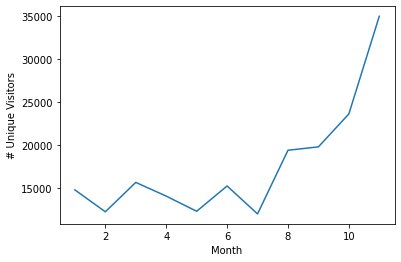

In [31]:
plot_metric_by_month(num_unique_visitors, '# Unique Visitors')

Quite a drastic increase in the number of unique visitors per month. Is this because the company is becoming more successful, or is it just a seasonal pattern with more unique visitors towards the end of the year because of back-to-school and colder weather? Hard to tell with only a year's worth of data..

**Purchases Per Month**

In [32]:
num_purchases = [len(group[1].loc[group[1]['purchased'] > 0]) for group in interactions_by_month]

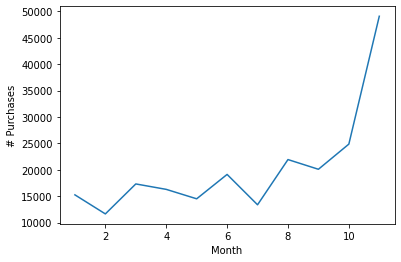

In [33]:
plot_metric_by_month(num_purchases, '# Purchases')

The number of purchases per month follows a very similar pattern to the number of visitors per month. 

**User-item interactions that include a purchase**

In [34]:
total_user_item_interactions = [group[1].groupby(['user_no', 'item_no']).ngroups for group in interactions_by_month]
user_item_interactions_purchase = [group[1].loc[group[1]['purchased'] > 0].groupby(['user_no', 'item_no']).ngroups
                                  for group in interactions_by_month]

conversion_by_month = np.array(user_item_interactions_purchase) / np.array(total_user_item_interactions)

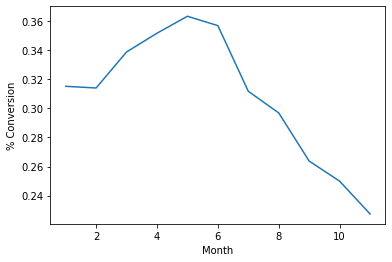

In [35]:
plot_metric_by_month(conversion_by_month, '% Conversion')

Even though the volume of sales/unique users/etc. goes up, the conversion goes down. This may represent an opportunity to boost sales; if we can raise the conversion towards the end of the year it will translate into a big win given the large number of users we see during these months. 

---
---

# **Cold Start** 

A frequent issue in recommendation systems is the [cold start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)). Cold start can be an especially big problem for collaborative filtering models (i.e. a model that relies solely on interaction history), since there may be many users or items for which there is no historical interaction data. 

Let's go through our data, and for each month find how many items/users are repeats (seen in previous months), and how many are new (never seen before). This could give us an idea of how big this problem is likely to be for us. 

To give a concrete example of the implications: imagine that every month nearly all of the site's visitors are completely new customers. This will have a profound effect for how we go about designing our recommendation system compared to a scenario in which nearly all of the site's visitors are repeat visitors. In the former scenario, we will know almost nothing about user's tastes and so may not even attempt any personalization (instead focusing on association rule mining or item-item recommendations), whereas in the latter scenario we can (hopefully) learn a lot of about what each user likes. 

In [36]:
user_set = set()
item_set = set()
num_new_users_by_month = []
num_new_items_by_month = []

num_repeat_users_by_month = []
num_repeat_items_by_month = []

for month, interaction_during_month in interactions_by_month:
    users_during_month = set(interaction_during_month['user_no'].unique())
    items_during_month = set(interaction_during_month['item_no'].unique())
    if month != 1: 
        new_users = users_during_month - user_set
        new_items = items_during_month - item_set
        repeat_users = users_during_month & user_set
        repeat_items = items_during_month & item_set
        
        num_new_users_by_month.append(len(new_users))
        num_new_items_by_month.append(len(new_items))
        num_repeat_users_by_month.append(len(repeat_users))
        num_repeat_items_by_month.append(len(repeat_items))

    user_set = user_set | users_during_month
    item_set = item_set | items_during_month

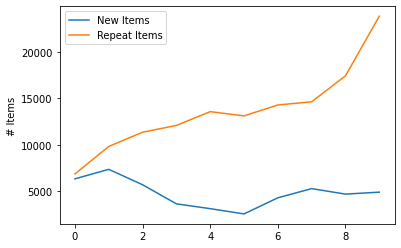

In [37]:
fig, ax = plt.subplots()
_ = ax.plot(num_new_items_by_month, label='New Items')
_ = ax.plot(num_repeat_items_by_month, label='Repeat Items')
_ = ax.set_ylabel('# Items')
_ = ax.legend()

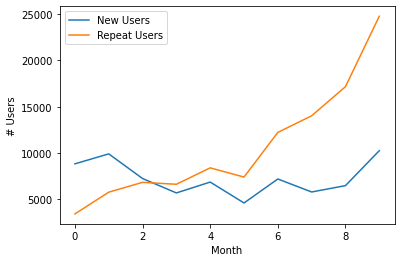

In [38]:
fig, ax = plt.subplots()
_ = ax.plot(num_new_users_by_month, label='New Users')
_ = ax.plot(num_repeat_users_by_month, label='Repeat Users')
_ = ax.set_ylabel('# Users')
_ = ax.set_xlabel('Month')
_ = ax.legend()

---
---

# **User Deep Dive**

In this section, we will try to get a better understanding of individual users. In particular we might ask questions such as, 

 + How many different items do users typically interact with? 
 + Are users very loyal to a particular brand?
 + Do users buy the same type of clothes?
 
It is often helpful to look at tons of examples to get a general idea of user behavior. This could help us model development by giving us an idea of what is important to a user. It can also be very helpful for model evaluation—are recommendations for a particular user consistent with their historical behavior? 

In [39]:
user_history_groups = user_item_interaction_w_metadata.groupby('user_no')

In [40]:
display(user_history_groups['item_no'].agg('count').describe())

count    87795.000000
mean         8.938060
std          6.336523
min          1.000000
25%          3.000000
50%          8.000000
75%         15.000000
max         20.000000
Name: item_no, dtype: float64

Most users have interacted with more than one item. 

In [41]:
user_history_groups['gender_description'].agg('nunique').describe()

count    87795.000000
mean         1.726123
std          0.751923
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: gender_description, dtype: float64

Some users only buy clothes of the same gender description. 

In [42]:
user_history_groups['brand'].agg('nunique').describe()

count    87795.000000
mean         4.686816
std          3.460774
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         20.000000
Name: brand, dtype: float64

Half of users buy from a small number (<5) of unique brands.

In [43]:
user_history_groups['product_group'].agg('nunique').describe()

count    87795.000000
mean         4.565203
std          3.116017
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         18.000000
Name: product_group, dtype: float64

Half of users interact with a small number (<5) of unique product groups. This is very helpful to know for recommendations. 

Below is a small helper function to display the history of a user. If no user is provided, a random user is selected and displayed. 

In [44]:
def display_user(df, user=None):
    if not user:
        user = random.choice(df['user_no'].unique())
        
    user_df = df[df['user_no'] == user]
    display(user_df)

<div class="alert alert-block alert-info">
<b>Tip:</b> Rerun the following cell multiple times to display different users and get an idea of how different users behave. 
</div>

In [45]:
display_user(user_item_interaction_w_metadata)

,user_no,item_no,addToCart,addToWishlist,pageView,purchased,first_interaction,colour,gender_description,brand,product_group,min_age,max_age
367777,-8781024177605072506,-1008145518948565581,0,0,1,1,2021-02-01,multi color,unisex,carena,bouncers and swings,NaN,NaN
367778,-8781024177605072506,-8774392829352461271,0,0,1,0,2021-05-07,grey,unisex,stokke,stroller accessories,NaN,NaN
367779,-8781024177605072506,374555410294867495,0,0,1,0,2021-02-01,multi color,unisex,carena,bouncers and swings,NaN,NaN


Here is an example of one particular user's history. Notice that they basically only buy toys, but also that the purchases were at around the same time. After we train a model, we could look at the recommendations that would be generated for this particular user to sense-check that the recommendations make sense. 

In [46]:
display_user(user_item_interaction_w_metadata, '3089645382551850482')

,user_no,item_no,addToCart,addToWishlist,pageView,purchased,first_interaction,colour,gender_description,brand,product_group,min_age,max_age
489607,3089645382551850482,-8514434943051020825,0,0,0,1,2021-11-23,beige,unisex,buddy & hope,first toys and baby toys,0.125,6.0
489608,3089645382551850482,1682361773976564047,0,0,1,0,2021-11-23,yellow,unisex,buddy & hope,textile,NaN,NaN
489609,3089645382551850482,2995614161312124464,0,0,1,1,2021-11-23,beige,unisex,stoy,role play,2.000,6.0
489610,3089645382551850482,585059380109681681,0,0,1,0,2021-11-22,grey,unisex,stoy,first toys and baby toys,0.125,6.0
489611,3089645382551850482,8252940203222144649,0,0,1,0,2021-11-23,beige,unisex,stoy,first toys and baby toys,0.125,6.0
489612,3089645382551850482,8818496003429638190,2,0,2,1,2021-11-22,pink,unisex,stoy,first toys and baby toys,0.125,6.0


---
---
# **Seasonality**

Intuitively, the types of items sold should differ over the course of the year. If that is indeed the case, it could be very useful infromation to encode into our model somehow. 

### **Item Types Over Time**

In [47]:
user_item_interaction_w_metadata['first_interaction_month'] = pd.to_datetime(
    user_item_interaction_w_metadata['first_interaction']).dt.month
user_item_interaction_purchases = user_item_interaction_w_metadata.loc[
    user_item_interaction_w_metadata['purchased'] > 0]

Let's limit ourselves to the top 25 most popular product groups. 

In [48]:
user_item_interaction_purchases_filtered = user_item_interaction_purchases.loc[
    user_item_interaction_purchases['product_group'].isin(
    user_item_interaction_purchases['product_group'].value_counts()[:25].index)]

table = pd.pivot_table(user_item_interaction_purchases_filtered[['first_interaction_month', 'product_group', 'user_no']], 
                      index=['first_interaction_month'], 
                      columns=['product_group'], 
                      aggfunc='count', 
                      fill_value=0)

table.columns = [column[1] for column in table.columns]

In [49]:
display(table)

,all in ones,baby feeding,baselayers,bicycles and other vehicles,boots,bottoms,clothing sets,coats and jackets,coveralls,dresses,...,jumpers and knitwear,role play,sandals,shorts,stroller accessories,swimwear and coverups,textile,tops,trainers,underwear
first_interaction_month,,,,,,,,,,,,,,,,,,,,,
1,919,307,695,88,972,988,284,668,1404,390,...,779,149,41,140,331,124,135,1304,187,618
2,452,191,74,92,328,662,553,664,599,518,...,479,71,144,176,215,244,178,1124,298,499
3,597,370,33,305,723,934,499,1172,555,619,...,558,617,353,246,361,504,186,1518,722,573
4,668,252,19,604,398,955,247,934,268,695,...,568,123,666,371,352,989,218,1908,739,537
5,632,213,17,163,256,673,176,529,114,672,...,468,173,1262,460,387,1401,211,1641,426,436
6,793,255,12,284,185,711,236,630,123,1031,...,607,103,2575,468,608,1762,275,2200,654,544
7,522,177,12,165,219,946,321,538,213,893,...,1170,148,257,243,443,569,161,1736,269,415
8,646,331,68,300,1274,1559,1446,1578,996,722,...,1039,447,148,100,801,157,248,1630,681,576
9,667,165,139,192,2066,1473,695,1666,1222,844,...,1385,128,113,63,271,99,203,1790,439,755


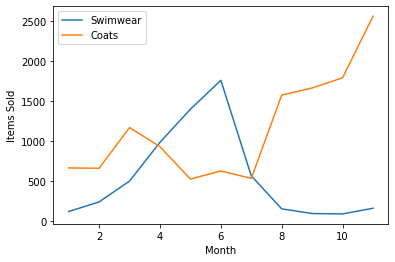

In [50]:
fig, ax = plt.subplots()
_ = ax.plot(table['swimwear and coverups'], label='Swimwear')
_ = ax.plot(table['coats and jackets'], label='Coats')
_ = ax.set_ylabel('Items Sold')
_ = ax.set_xlabel('Month')
_ = ax.legend()

There seems to be evidence of seasonality in terms of products bought, as we would expect. This indicates that time-based features could be very helpful. 

---
---

# **Create Training and Eval Data**

Quoting from the [TFRS Retrieval Tutorial](https://www.tensorflow.org/recommenders/examples/basic_retrieval):

> To fit and evaluate the model, we need to split it into a training and evaluation set. In an industrial recommender system, this would most likely be done by time: the data up to time $T$ would be used to predict interactions after $T$.

As in that tutorial, however, we will just use a random split to keep things simple. We will put 85% of the ratings in the train set, and 15% in the test set. 

In [51]:
COLS_TO_KEEP = ['user_no', 'item_no', 'gender_description', 'brand', 'product_group', 'first_interaction_month']

train, test = train_test_split(user_item_interaction_w_metadata[COLS_TO_KEEP], test_size=.15)

In [52]:
train

,user_no,item_no,gender_description,brand,product_group,first_interaction_month
509851,3514657341026450752,-8200171396217105230,girls,jacadi,all in ones,5
73397,-2544835772752526495,6010486836306001722,unisex,done by deer,tableware,11
236524,-6023760384625599940,-289310928076258010,unisex,axkid,car seat accessories,2
536214,4084143572023326121,-1069008842172275553,boys,pom dapi,sandals,5
176626,-4787976733877481713,608763176274829755,unisex,little luwi,tops,8
...,...,...,...,...,...,...
636665,6183491195824661353,-487489333946043722,girls,ikks,dresses,4
333574,-8074445800271606192,7154496603299236573,unisex,tommee tippee,baby feeding,3
525948,3873852775369901008,3465194094158419708,unisex,by nils,sandals,5
14376,-1306455725574612144,2424760068735106973,girls,kenzo,tops,1


In [53]:
test

,user_no,item_no,gender_description,brand,product_group,first_interaction_month
708469,7693727551294790833,-7584944717366428223,unisex,reima,coveralls,1
393368,1023419668496186811,442223940309080467,unisex,buddy & hope,baby feeding,2
314947,-7695673821753121214,-3839781135117815982,boys,jacadi,trainers,6
703497,7591254236464661898,-6587371748314417850,unisex,kuling,coats and jackets,10
328256,-7976417315465112603,738378393155238500,unisex,reima,headwear,11
...,...,...,...,...,...,...
266398,-6674738972262967141,-7183709535155657129,unisex,kuling,coats and jackets,6
763859,8863485878443988978,4060095639948956788,unisex,bobo choses,shorts,5
60596,-2270533177868667442,8643279659370136534,unisex,yporqué,headwear,11
94832,-3000905857160918109,-2346495051990167677,unisex,kuling,clothing sets,8


In [54]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

---
---


# **Appendix** 

The following cells are just meant as examples of how one could go about writing out the data as TFRecords. Using TFRecords can be very helpful for large datasets, but for this example it is not necessary. 

In [55]:
COLS_TO_KEEP = ['user_no', 'item_no', 'gender_description', 'brand', 'product_group']

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def create_example(instance):
    features = {}
    for key, val in instance.items(): 
        features[key] = bytes_feature(val)
    return tf.train.Example(features=tf.train.Features(feature=features))

def serialize_example(example):
    return example.SerializeToString()

def create_feature_description(): 
    feature_description = {
        key: tf.io.FixedLenFeature([], tf.string) for key in COLS_TO_KEEP
    }
    return feature_description

def parse_example(serialized_example, feature_description):
    return tf.io.parse_single_example(serialized_example, feature_description)

def write_tf_record(df, filename):
    with tf.io.TFRecordWriter(filename) as writer: 
        for row, instance in df.iterrows():
            example = create_example(instance)
            serialized_example = serialize_example(example)
            writer.write(serialized_example)

In [ ]:
write_tf_record(train[COLS_TO_KEEP], 'train.tfrecord')
write_tf_record(test[COLS_TO_KEEP], 'test.tfrecord')

In [ ]:
feature_description = create_feature_description()

In [ ]:
raw_train_dataset = tf.data.TFRecordDataset('train.tfrecord')
parsed_train_dataset = raw_train_dataset.map(lambda x: (parse_example(x, feature_description)))

for parsed_instance in parsed_train_dataset.take(3):
    print(parsed_instance)